<a href="https://colab.research.google.com/github/MatiasSiles/MastercardSalesOptimization/blob/main/Fraud_Detection_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de detección temprana de anomalías y fraudes financieros multivariado con series temporales, usando Deep Learning (LSTM/Transformer) y métodos bayesianos para estimar riesgo dinámico en transacciones Mastercard a nivel global.

Detección en tiempo real de fraudes invisibles de bajo monto, usando anomalías multivariada

In [ ]:
import sqlite3
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!unzip -q /content/ne_110m_admin_0_countries.zip

In [ ]:
connection_db = sqlite3.connect("mastercard.db")

df_customers = pd.read_sql("SELECT * FROM customers", connection_db)
df_cards = pd.read_sql("SELECT * FROM cards", connection_db)
df_merchants = pd.read_sql("SELECT * FROM merchants", connection_db)
df_transactions = pd.read_sql("SELECT * FROM transactions", connection_db)
df_fraud_labels = pd.read_sql("SELECT * FROM fraud_labels", connection_db)

connection_db.close()

In [ ]:
class fraud_analyzer():
  def __init__(self, * ,customers=None, transactions=None, cards=None, fraud_labels=None):
    self.customers = customers
    self.transactions = transactions
    self.cards = cards
    self.fraud_labels = fraud_labels

  def Customers(self):
    fig, axes = plt.subplots(3,2, figsize=(16,8))
    fig.suptitle("Customers Analysis")

    # plot1
    axes[0,0].scatter(self.customers["age"], self.customers["income"], alpha=0.4)
    axes[0,0].set_xlabel("Age")
    axes[0,0].set_ylabel("Income")

    # plot2
    idcustomer_idtransaction_amount = pd.merge(self.cards, self.transactions, on="card_id")[["customer_id", "transaction_id","amount"]]
    income_vs_amount = pd.merge(idcustomer_idtransaction_amount, self.customers, on="customer_id")[["income", "amount"]]

    axes[0,1].scatter(income_vs_amount["income"], income_vs_amount["amount"], alpha=0.2)
    axes[0,1].set_xlabel("Income")
    axes[0,1].set_ylabel("Transaction Amount")

    # plot3
    axes[1,0].hist(idcustomer_idtransaction_amount["customer_id"], bins=50)
    axes[1,0].set_xlabel("Customer ID")
    axes[1,0].set_ylabel("Transaction Frequency")

    # plot4
    data = pd.merge(self.cards, self.transactions, on="card_id")[["customer_id","amount"]]
    data = data.groupby("customer_id").mean()

    axes[1,1].scatter(data.index, data["amount"], alpha=0.3)
    axes[1,1].set_xlabel("Customer ID")
    axes[1,1].set_ylabel("Average Transaction Amount")

    # plot5
    self.transactions["timestamp"] = pd.to_datetime(self.transactions["timestamp"])
    frequency_transaction_hour = self.transactions["timestamp"].dt.hour.sort_values()

    axes[2,0].hist(frequency_transaction_hour)
    axes[2,0].set_xlabel("Hour")
    axes[2,0].set_ylabel("Transaction Frequency")

    # plot6
    frequency_transaction_date = self.transactions["timestamp"].sort_values()
    frequency_transaction_date = self.transactions["timestamp"].dt.date
    frequency_transaction_date = pd.to_datetime(self.transactions["timestamp"])

    axes[2,1].hist(frequency_transaction_date, bins=80)
    axes[2,1].set_xlabel("Date")
    axes[2,1].set_ylabel("Transaction Frequency")

    fig.tight_layout()

  def transaction_customer_map(self):
    world_map = gpd.read_file("/content/ne_110m_admin_0_countries.shp")

    countries = self.customers["country"].value_counts().reset_index().rename(columns={"country":"ISO_A2"})
    world_map = pd.merge(world_map, countries, on="ISO_A2")

    world_map.plot(column="count", cmap="OrRd", legend=True, color="lightblue", figsize=(20,8))

  def fraud_distribution(self):
    data = self.fraud_labels["is_fraud"].value_counts()
    data.plot(kind="bar")
    frauds_total = data.iloc[data.index == 1].item()
    fraud_porcent = (frauds_total * 100) / len(self.fraud_labels)

    print(data)
    print(f"\nFraud Porcent: {fraud_porcent}")

fraud_analyzer = fraud_analyzer(customers=df_customers, transactions=df_transactions, cards=df_cards, fraud_labels=df_fraud_labels)

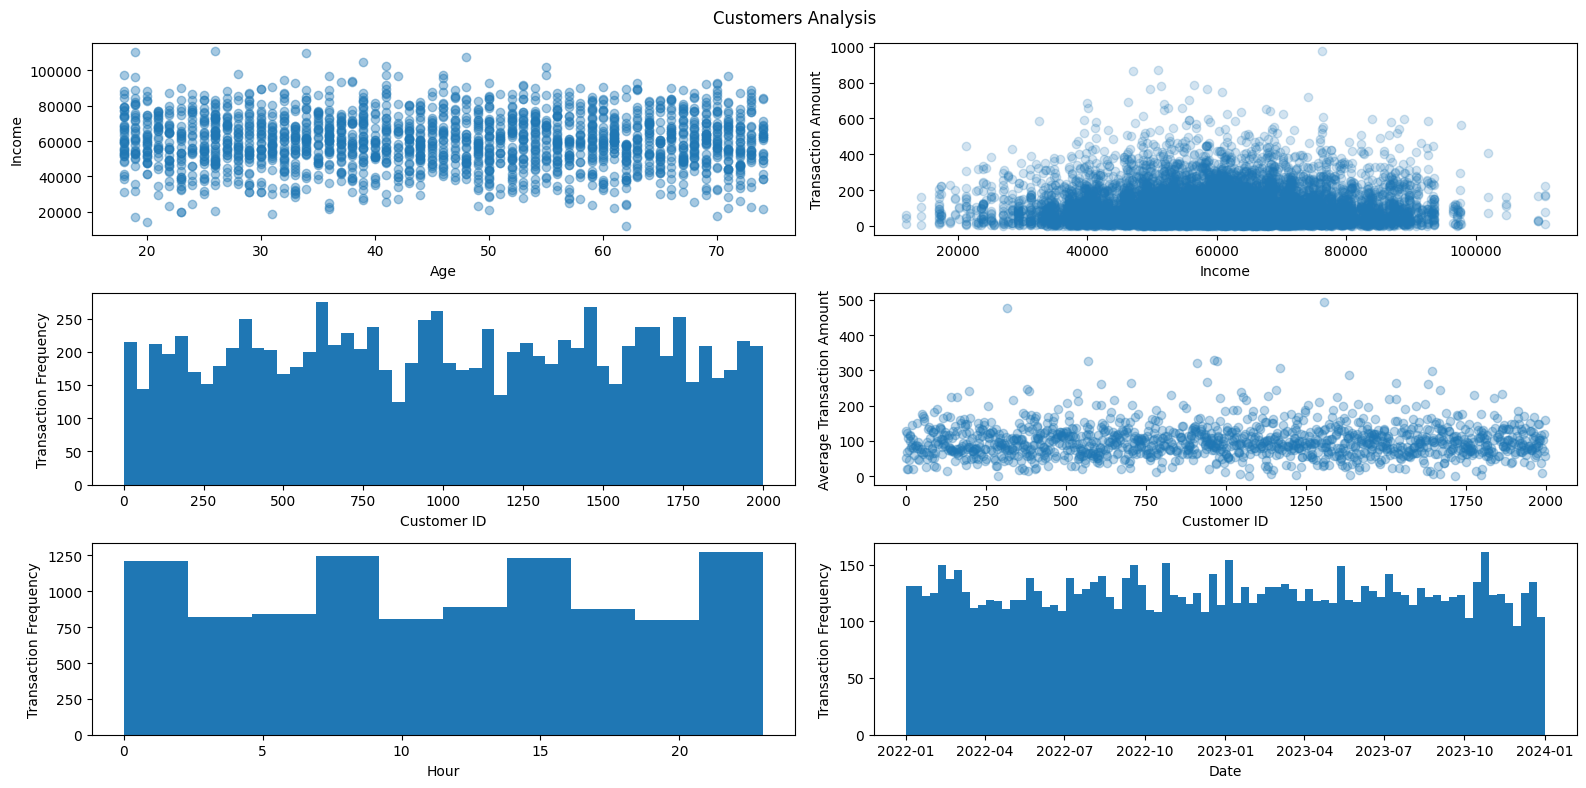

In [ ]:
fraud_analyzer.Customers()

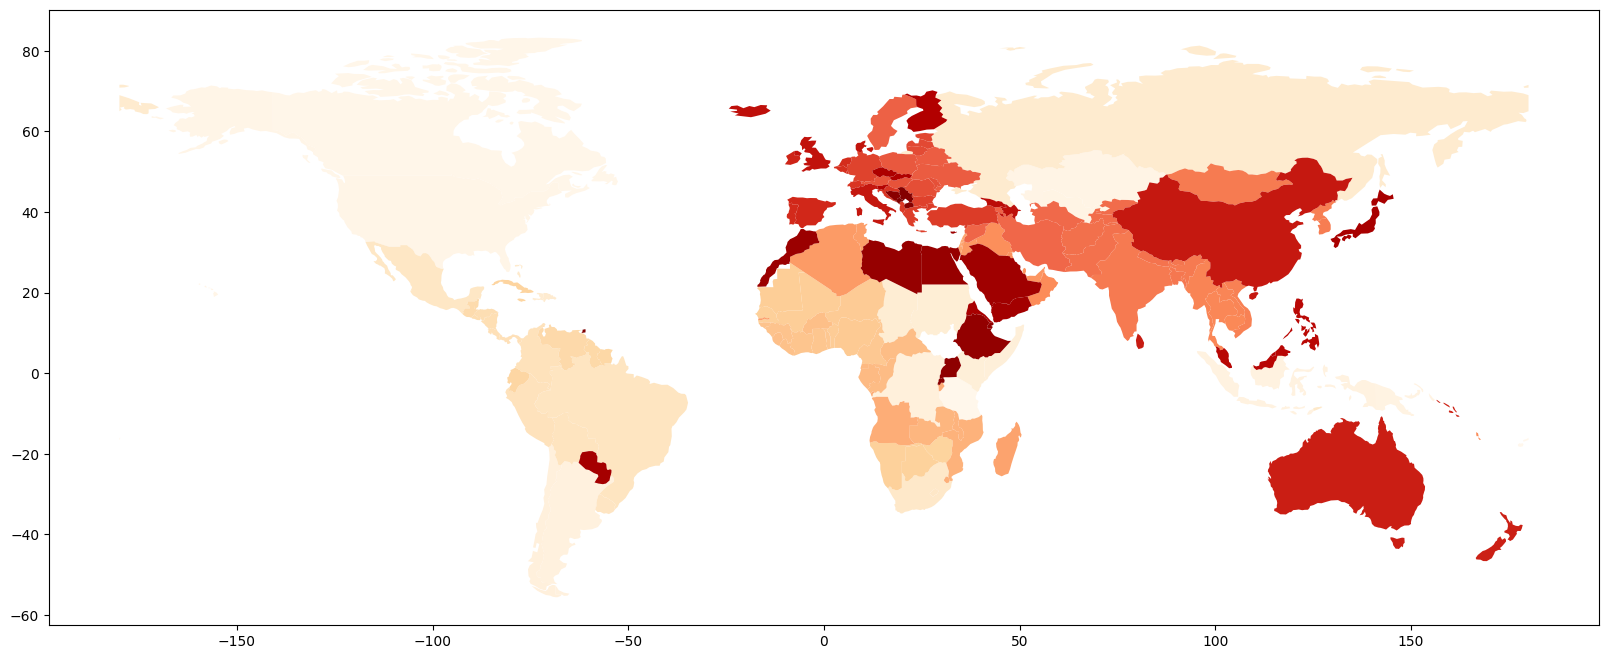

In [ ]:
fraud_analyzer.transaction_customer_map()

is_fraud
0    9781
1     219
Name: count, dtype: int64

Fraud Porcent: 2.19


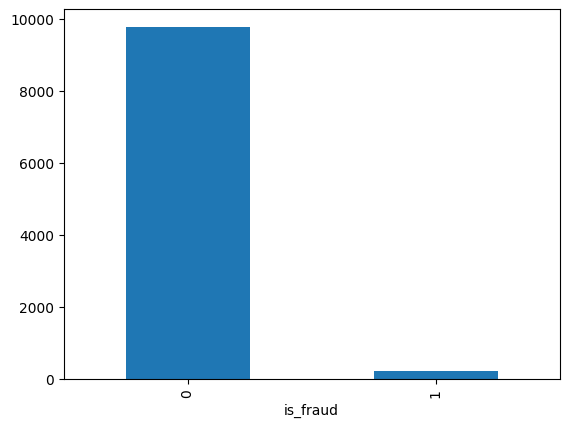

In [ ]:
fraud_analyzer.fraud_distribution()